In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

APP_FILE = "application"
INFRA_FILE = "infrastructure"
SIM_FILE = "simulation"
base_path = Path("./results")
plot_path = Path(base_path / "plots")
plot_path.mkdir(exist_ok=True, parents=True)

FONT_SIZE = "large"

In [2]:
app_df = pd.read_parquet(base_path / f"{APP_FILE}.parquet")
sim_df = pd.read_parquet(base_path / f"{SIM_FILE}.parquet")

In [3]:
dfs = {"application": app_df, "simulation": sim_df}

In [4]:
for df in dfs.values():
    df["n_event"] = df["n_event"].astype(int)
    df["load"] = df["load"].astype(float)
    df["nodes"] = df["nodes"].astype(int)
    df["seed"] = df["seed"].astype(int)

NODES = app_df["nodes"].unique()

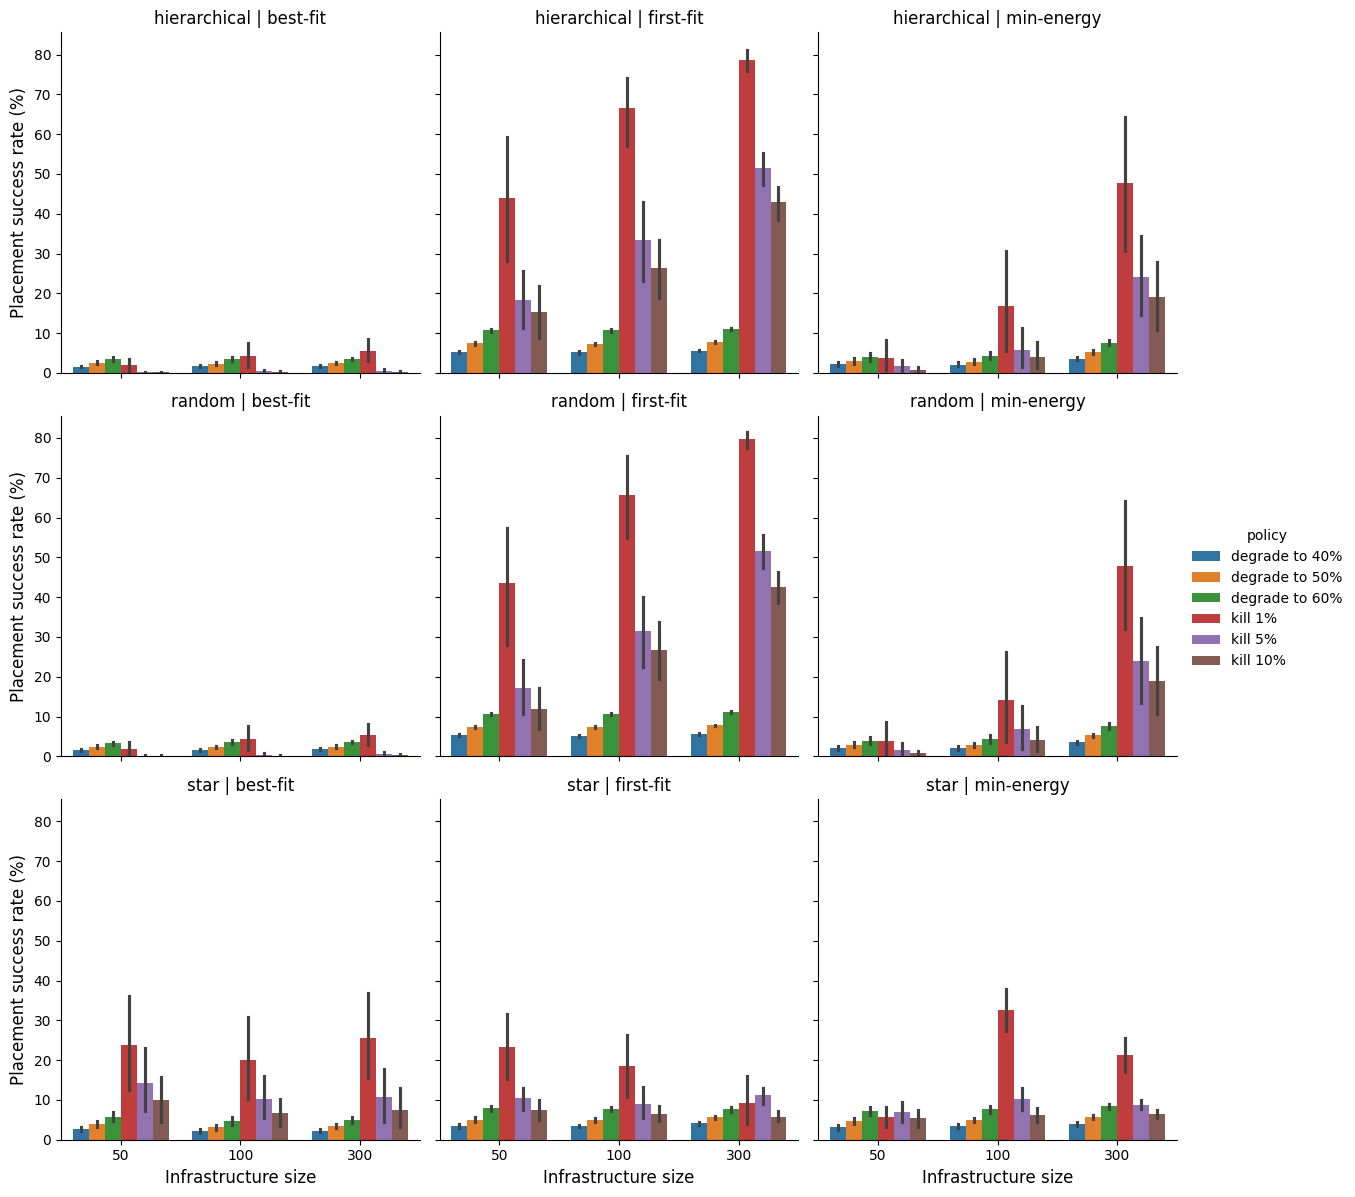

In [12]:
df_pl_rate = app_df.copy()
group_by = ["nodes", "strategy", "topology", "seed", "load"]

df_pl_rate = df_pl_rate[
    (df_pl_rate["callback_id"] == "is_placed")
    & (df_pl_rate["policy"] != "ensure")
    & (df_pl_rate["strategy"] != "random")
]

df_pl_rate["value"] = df_pl_rate["value"] == "True"

df_pl_rate = df_pl_rate.groupby(group_by + ["policy"])["value"].mean().reset_index()
df_pl_rate.set_index(group_by, inplace=True)

df_pl_rate["percentage"] = (df_pl_rate["value"] * 100).dropna()
df_pl_rate.reset_index(inplace=True)

hue_order = [
    "degrade to 40%",
    "degrade to 50%",
    "degrade to 60%",
    "kill 1%",
    "kill 5%",
    "kill 10%",
]


f = sns.catplot(
    data=df_pl_rate,
    x="nodes",
    y="percentage",
    hue="policy",
    col="strategy",
    row="topology",
    kind="bar",
    height=4,
    aspect=1,
    order=sorted(NODES),
    hue_order=hue_order,
)

for ax in f.axes.flat:
    ax.set_xlabel("Infrastructure size", fontsize=FONT_SIZE)
    ax.set_ylabel("Placement success rate (%)", fontsize=FONT_SIZE)

f.set_titles(row_template="{row_name}", col_template="{col_name}", size=FONT_SIZE)
f.savefig(plot_path / "pl_success_rate.pdf", dpi=600, format="pdf")
plt.show()